<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Retreive-data-from-cache" data-toc-modified-id="Retreive-data-from-cache-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Retreive data from cache</a></span></li><li><span><a href="#Performance-debugging" data-toc-modified-id="Performance-debugging-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Performance debugging</a></span><ul class="toc-item"><li><span><a href="#Look-at-contraction-backends" data-toc-modified-id="Look-at-contraction-backends-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Look at contraction backends</a></span></li><li><span><a href="#Look-at-large-circuits" data-toc-modified-id="Look-at-large-circuits-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Look at large circuits</a></span></li><li><span><a href="#Look-at-small-circuit-time" data-toc-modified-id="Look-at-small-circuit-time-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Look at small circuit time</a></span></li></ul></li><li><span><a href="#Ordering-using-different-algos-vs-time-for-fixed-p,-N" data-toc-modified-id="Ordering-using-different-algos-vs-time-for-fixed-p,-N-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Ordering using different algos vs time for fixed p, N</a></span><ul class="toc-item"><li><span><a href="#Verify-merged-indices" data-toc-modified-id="Verify-merged-indices-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Verify merged indices</a></span></li></ul></li><li><span><a href="#Debugging-of-quimb" data-toc-modified-id="Debugging-of-quimb-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Debugging of quimb</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [1]:
#export
import numpy as np
import qtensor
import quimb
import sys
import pyrofiler.c as profile
#sys.path.pop(2)

from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
from qtensor.tests.acqdp_qaoa import single_qaoa_query as simulate_acqdp_energy
import matplotlib.pyplot as plt
import time
import xarray

from cartesian_explorer import Explorer, caches, parallels

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export
cache = caches.JobLibCache('../../caex_cache/skylake_speed_comparison')
PAR = True
if PAR:
    parallel = parallels.Ray(processes=25)
    ex = Explorer(cache=cache, parallel=parallel)
else:
    ex = Explorer(cache=cache)

2021-04-20 02:31:21,930	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtensor.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [5]:
#export
@ex.provider
def simulator(sim, qtn_backend='einsum', accelerated=False):
    simulators = qtensor.tools.benchmarking.simulators
    return {
        'qtensor': simulators.QtensorSimulator(backend=qtn_backend),
        'qtensor_merged': simulators.MergedQtensorSimulator(backend=qtn_backend),
        'qtensor_merged_mkl': simulators.MergedQtensorSimulator(backend='mkl'),
        'qtensor_merged_tr': simulators.MergedQtensorSimulator(backend='tr_einsum'),
        'qtensor_merged_tr_acc': simulators.MergedQtensorSimulator(
            backend='tr_einsum', accelerated=True
        ),
        'quimb': simulators.QuimbSimulator(),
        'quimb_faster': simulators.QuimbSimulator(
            opt_type='uniform', opt_kwargs=dict(methods=['greedy'], reconf_opts={'subtree_size': 6})
        ),
        'quimb_better': simulators.QuimbSimulator(
            opt_type='hyper', opt_kwargs=dict(reconf_opts={})
        ),
        'quimb_Dsimp': simulators.QuimbSimulator(simplify_sequence='D'),
        'acqdp': simulators.AcqdpSimulator(),
        'qiskit': simulators.QiskitSimulator()
    }[sim]

In [6]:
@ex.add_function(provides=('opts', 'energy_flops', 'energy_opt_time', 'energy_mem_est', 'energy_tws')
                 , requires=('graph', 'p', 'simulator')
                )
def energy_cost(graph, p,
                simulator,
                sim='qtensor',
                qtn_ordering_algo='greedy',
                qmb_max_repeats=10,
               ):
    kwargs = {}
    if 'qtensor' in sim:
        kwargs['ordering_algo'] = qtn_ordering_algo
    elif 'quimb' in sim:
        kwargs['max_repeats'] = qmb_max_repeats
    try:
        opts, ests, time = simulator.optimize_qaoa_energy(graph, p, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None, None, None, None
    flops = [est.flops for est in ests]
    mems = [est.mems for est in ests]
    tws = [est.width for est in ests]
    print(flops)
    return opts, sum(flops), time, max(mems), tws
        

In [7]:
@ex.add_function(provides=('energy_time', 'energy_memory')
                 , requires=('graph', 'p', 'simulator', 'opts')
                )
def energy_time(graph, p, simulator, opts,
                sim='qtensor',
               ):
    kwargs = {}
        
    try:
        res, time, memory = simulator.simulate_qaoa_energy(graph, p, opts, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None
    return time, memory

In [8]:
@ex.provider
def energy_max_tw(energy_tws):
    if energy_tws is None:
        return None
    return np.nanmax(np.array(energy_tws).astype(np.float))

@ex.provider
def energy_mean_tw(energy_tws):
    if energy_tws is None:
        return None
    return np.nanmean(np.array(energy_tws).astype(np.float))

In [9]:
_time = ex.get_variable('energy_time', sim='qiskit', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qiskit', N=10, p=2)
print(_time, _mem)

[2048]
0.48635196685791016 3604480


In [10]:
_time = ex.get_variable('energy_time', sim='qtensor_merged_tr', N=56, p=2)
_mem = ex.get_variable('energy_memory', sim='qtensor_merged_tr', N=56, p=2)
print(_time, _mem)


[5620, 5088, 5924, 7860, 4568, 2376, 4300, 2280, 2344, 2376, 2344, 4324, 3028, 2376, 2344, 2948, 2376, 2344, 4884, 4868, 4520, 2344, 2344, 4300, 2376, 2280, 4472, 4488, 3928, 3928, 4416, 2344, 2376, 5028, 5156, 5028, 2948, 4472, 4324, 4996, 2376, 2280, 2948, 2344, 2344, 2344, 2344, 2376, 2376, 2376, 2344, 2376, 2376, 4888, 4300, 4488, 2948, 5392, 4316, 5380, 3636, 2376, 2376, 3928, 2344, 2344, 2948, 5028, 3928, 4520, 4300, 2948, 6224, 4416, 2344, 5028, 2948, 2344, 2376, 2344, 2344, 2344, 2376, 2376]


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:228: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)



0.901099681854248 12288


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:228: UserWarning: Persisting input arguments took 2.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)


In [15]:
_time = ex.get_variable('energy_time', sim='qtensor_merged_tr_acc', N=54, p=2)
_mem = ex.get_variable('energy_memory', sim='qtensor_merged_tr_acc', N=54, p=2)
print(_time, _mem)

eorbits time 0.0323789119720459



[2376, 6352, 4996, 2948, 7172, 8596]
eorbits time 0.021390199661254883



eorbits time 0.021917104721069336



0.11310052871704102 0


In [19]:
_time = ex.get_variable('energy_time', sim='acqdp', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='acqdp', N=10, p=2)
print(_time, _mem)

Preprocessing for energy query...



Preprocessing time for queries: 0.4531998634338379
[Decimal('3592'), Decimal('5680'), Decimal('3812'), Decimal('5744'), Decimal('6128'), Decimal('9000'), Decimal('9352'), Decimal('2980'), Decimal('4096'), Decimal('2404'), Decimal('5928'), Decimal('5136'), Decimal('3080'), Decimal('3736'), Decimal('1948')]



E([0.3975954791721537, 0.9729575607465271, -0.3905740193268042, 1.1221314505504383]) = (-2.9757312901800854+5.025755855342816e-17j)
0.03567695617675781 0


In [10]:
_time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb', N=54, p=4, seed=10)
_tw = ex.get_variable('energy_tws', sim='quimb', N=54, p=4, seed=10)
print(_time, _mem, _tw)

simp kw {'simplify_sequence': 'ADCRS'} ADCRS



[83544992, 58734520, 114390488, 87412928, 30471892, 3699968, 75113792, 31695584, 411154128, 4518786616, 175746532, 106278216, 1651546352, 438028160, 453810584, 95359988, 196449280, 436571164, 63786560, 173160488, 422222048, 258329996, 19742712408, 171490512, 23681936, 40294784, 92928544, 29157992, 38224656, 381393504, 61021248, 329541652, 33057532, 87164912, 3852669780, 314380656, 1120386000, 906937072, 459869236, 315257780, 21765740, 426189856, 213962672, 89028848, 150418088, 154761556, 162571740, 1358245200, 98351460, 62497248, 41068612, 32886424, 265626152, 7609984, 90748392, 9023449840, 34634567164, 120580400, 1671018936, 3733135880, 63997836, 109807392, 57034736, 93323152, 3366257668, 525838408, 361709612, 64906644, 62255672, 62335616, 54225036, 8220748, 3965912, 9509216, 41615404, 10305376, 239697540, 127218768, 446274432, 26874876, 38834896]
simulating energy



error Internal error while evaluating `ContractExpression`. Note that few checks are performed - the number and rank of the array arguments must match the original expression. The internal error was: '('too many subscripts in einsum',)'


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:224: UserWarning: Persisting input arguments took 9.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)


None None [19.0, 21.0, 22.0, 20.0, 17.0, 16.0, 20.0, 18.0, 24.0, 22.0, 22.0, 21.0, 23.0, 22.0, 22.0, 19.0, 22.0, 21.0, 21.0, 22.0, 21.0, 22.0, 25.0, 20.0, 19.0, 19.0, 20.0, 20.0, 18.0, 22.0, 21.0, 22.0, 19.0, 20.0, 24.0, 22.0, 22.0, 24.0, 23.0, 20.0, 18.0, 22.0, 20.0, 19.0, 19.0, 20.0, 20.0, 24.0, 20.0, 19.0, 19.0, 19.0, 21.0, 17.0, 19.0, 27.0, 28.0, 21.0, 21.0, 25.0, 21.0, 19.0, 21.0, 21.0, 25.0, 22.0, 23.0, 20.0, 20.0, 19.0, 19.0, 15.0, 14.0, 17.0, 19.0, 18.0, 21.0, 21.0, 24.0, 18.0, 21.0]


In [11]:
_time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb_Dsimp', N=54, p=4, seed=10)
_tw = ex.get_variable('energy_tws', sim='quimb_Dsimp', N=54, p=4, seed=10)
print(_time, _mem, _tw)

simp kw {'simplify_sequence': 'D'} D


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.




Traceback (most recent call last):
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-c0186bf7a92f>", line 1, in <module>
    _time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb_Dsimp', N=54, p=4, seed=10)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py", line 224, in get_variables
    retval = f(**call_kwd)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 591, in __call__
    return self._cached_call(args, kwargs)[0]
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 534, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/joblib/memory.py", line 761, in call
    output = self.func(*args, **kwargs)
  File "<ipython-input-6-ecc8c3ea0adc>"

KeyboardInterrupt: 

## Generate data

In [11]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws', 'energy_max_tw',
         'energy_time', 'energy_memory'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [14]:
Ns = 2*(.5*np.pi**(np.arange(0, 14)/2)).astype(np.int) + 10
Ns = Ns[3:10]

ps = [3, 4] 
seeds = [10, 12, 13]
n_repeats = 10

In [15]:
xar = gen_time_data(Ns, ps, n_processes=[1],
                    sim=['acqdp', 'quimb', 'qtensor', 'qtensor_merged_tr'],
                    qtn_ordering_algo=[f'rgreedy_0.02_{n_repeats}'],
                    qmb_max_repeats=[n_repeats],
                    qiskit_method=['matrix_product_state'],
                    seed=seeds
                   )
xar

_dimcount 5


/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<xarray.DataArray (varname: 7, p: 2, N: 7, sim: 4, seed: 3)>
array([[[[[Decimal('10682292'), Decimal('73874800'),
           Decimal('38516408')],
          [2479284, 12504816, 6997216],
          [4756532, 21462938, 14865886],
          [4971430, 19022876, 15211102]],

         [[Decimal('64884924'), Decimal('52300648'),
           Decimal('78940728')],
          [14800300, 8886228, 13905540],
          [24861406, 16769968, 18994590],
          [25616784, 18816266, 24358432]],

         [[Decimal('32314672'), Decimal('21870960'),
           Decimal('18447368')],
          [5435584, 5844984, 5197016],
          [10179646, 10598886, 9181954],
          [8248130, 9032852, 8303386]],

         ...,

...
          [151916544, 783405056, 1190203392],
          [470298624, 2125836288, 5298286592],
          [40312832, 687276032, 3562598400]],

         ...,

         [[2676830208, None, None],
          [5364625408, 3180605440, 1638731776],
          [1091563520, 5481566208, 1383038976],
          [84193280, 338513920, 186114048]],

         [[701984768, None, 2147061760],
          [100671488, 3214880768, 3221463040],
          [89092096, 1742376960, 675762176],
          [27791360, 66547712, 45895680]],

         [[203923456, 2408775680, 1352994816],
          [126410752, 806162432, 169365504],
          [22941696, 110166016, 103018496],
          [0, 21467136, 46874624]]]]], dtype=object)
Coordinates:
  * varname  (varname) <U15 'energy_flops' 'energy_mem_est' ... 'energy_memory'
  * p        (p) int64 3 4
  * N        (N) int64 14 18 26 40 64 106 182
  * sim      (sim) <U17 'acqdp' 'quimb' 'qtensor' 'qtensor_merged_tr'
  * seed     (seed) int64 10 12 13

## Read data

In [ ]:
xar = xarray.load_dataarray('../../../second_try.nc')

## Retreive data from cache

In [16]:
dims = dict(
    varnames=['energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws','energy_max_tw',
     'energy_time', 'energy_memory'],
    p=ps,
    N=Ns,
    n_processes=[1],
    sim=['qiskit', 'acqdp', 'quimb', 'qtensor', 'qtensor_merged_tr'],
    qtn_ordering_algo=[f'rgreedy_0.02_{n_repeats}'],
    qmb_max_repeats=[n_repeats],
    qiskit_method=['matrix_product_state'],
    seed=seeds
)

data = ex.map_variables_no_call( **dims  )

In [23]:
_dimcount = len(data.shape)
_dimnames = list(dims.keys())
dimvals = {k:dims[k] for k in _dimnames if len(dims[k])>1}

xar = xarray.DataArray(data, dims=list(dimvals.keys()), coords=dimvals)

In [14]:
#xar.to_netcdf('../../../data/speed_comparison.nc')

In [17]:
def plot_xarray(ex, xar, **kwargs):
    dims = {k:xar.coords[k].data for k in xar.dims}
    kwargs = {**kwargs, **dims}
    def safe_sel(*args, **kwargs):
        try:
            return xar.sel(*args, **kwargs).item()
        except Exception:
            return None
    print('kw', kwargs)
    fig = ex.plot(safe_sel, **kwargs)
    return fig

In [18]:
def data_lists_mean(line_data):
    """[
    [
    [[0, 1, 2], None ], [None, None]
    ]
    to [
    [1, None], [None, None]
    ]
    """
    for i, pt in enumerate(line_data):
        line_data[i] = [np.nanmean(np.array(x).astype(np.float)) if hasattr(x,'__iter__') else x for x in np.array(pt)]
        
    return line_data.astype(np.float)
    
def plot_with_band(x, line_data, **kwargs):
    # for tws
    line_data = data_lists_mean(line_data)
    
    line_data = line_data.astype(np.float64)
    maxs = np.max(line_data, axis=-1)
    mins = np.min(line_data, axis=-1)
    std = np.nanstd(line_data, axis=-1)
    mean = np.nanmean(line_data, axis=-1)
    relstd = (mean-std)/mean
    
    plt.plot(x, mean, '.-', **kwargs)
    fill_kwargs = dict(
        alpha=0.05, color=kwargs.get('color')
    )
    plt.fill_between(x, mean + std, mean - std, **fill_kwargs)
    

In [19]:
ex.set_size(5, 4)

In [40]:
if ex.parallel is not None:
    _par = ex.parallel
ex.parallel=None

kw {'plot_func': <function plot_with_band at 0x7f7730ddb0d0>, 'distribution_var': 'seed', 'varname': array(['energy_flops', 'energy_time', 'energy_mem_est', 'energy_memory',
       'energy_opt_time', 'energy_tws', 'energy_max_tw'], dtype='<U15'), 'sim': array(['qtensor', 'qtensor_merged_tr', 'acqdp', 'quimb'], dtype='<U17'), 'N': array([ 14,  18,  26,  40,  64, 106, 182]), 'seed': array([10, 12, 13])}


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/ExplorerBasic.py:219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)
/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-18-50779f4c232c>:23: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-18-50779f4c232c>:23: RuntimeWarning: Mean of empty slice
  mean = n

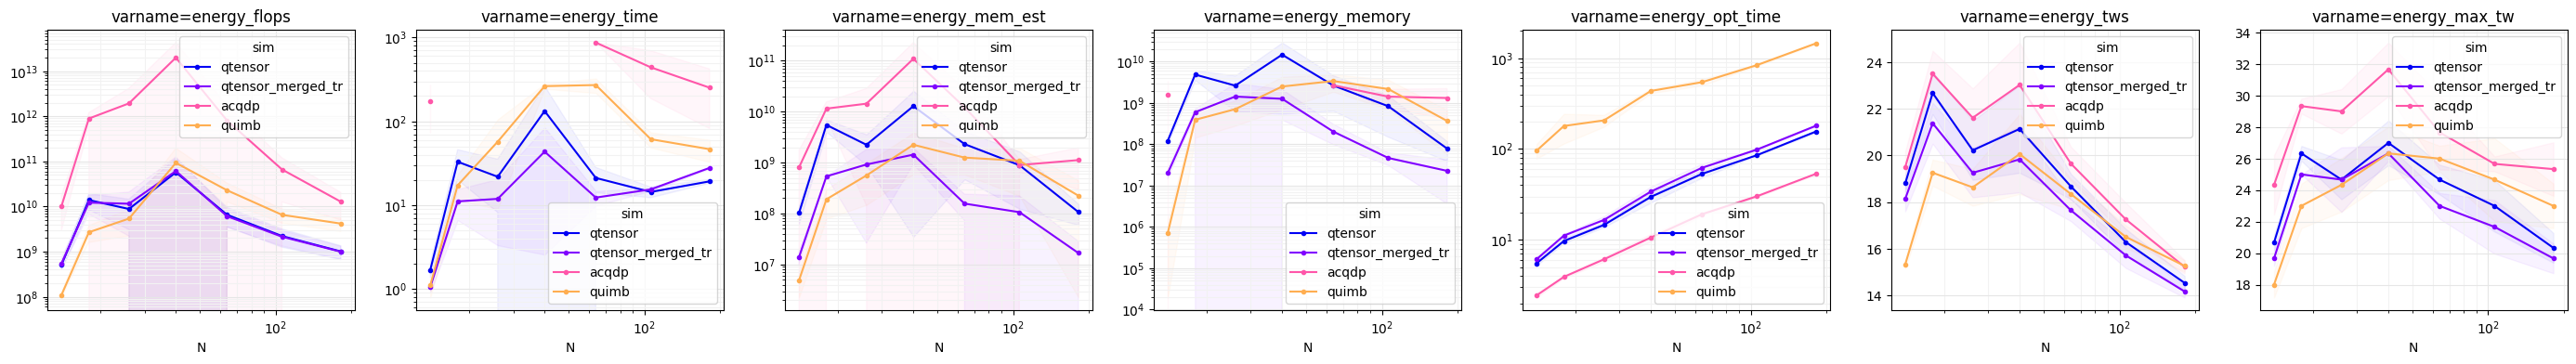

In [22]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

p = 4
fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops','energy_time',
             'energy_mem_est', 'energy_memory', 'energy_opt_time', 'energy_tws','energy_max_tw']
    #varname=['energy_tws' ]
   , sim=['qtensor', 'qtensor_merged_tr', 'acqdp', 'quimb' ]
   #, sim=['qtensor', 'qtensor_merged', 'acqdp', 'quimb', 'quimb_Dsimp']
    , p=p
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:5]:
    ax.set_yscale('log')
for ax in fig.axes:
    ax.set_xscale('log')
    
plt.savefig(f'../../../data/figures/speed_comparison_p{p}_nrep{n_repeats}.pdf')

In [42]:
ex.parallel = _par

In [20]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_time', 'energy_memory']
    #varname=['energy_tws' ]
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=5
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:2]:
    ax.set_yscale('log')

ValueError: ('p', 'varname', 'sim', 'N', 'seed') must be a permuted list of ('varnames', 'p', 'N', 'sim', 'seed'), unless `...` is included

## Performance debugging
### Look at contraction backends

In [14]:
_time = ex.get_variable('energy_time', sim='qtensor_merged', N=20, p=4, seed=13,
                        qtn_ordering_algo='rgreedy_0.02_10', qtn_backend='mkl')
_time

20.676586151123047

In [14]:
p = 5
Ns = 2*(.5*np.pi**(np.arange(0, 14)/2)).astype(np.int) + 10
Ns = Ns[3:6]

fig = ex.plot_variables(('energy_time')
                        , distribution_var='seed'
                        , qtn_backend=['einsum', 'tr_einsum', 'mkl']
                        , sim=['qtensor_merged', 'qtensor', 'quimb']
                        , qtn_ordering_algo=['rgreedy_0.02_10']
                        , qmb_max_repeats=[10]
                        , N=Ns
                        , seed=[10, 11]
                        , p=[p]
)


2021-03-06 01:51:21,604	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:51:47,507	WARNING worker.py:1091 -- A worker died or was killed while executing task d9a5dd8231409648ffffffff01000000.
2021-03-06 01:51:53,281	WARNING worker.py:1091 -- A worker died or was killed while executing task d623130793ad3e6cffffffff01000000.
2021-03-06 01:51:59,819	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:52:30,816	WARNING worker.py:1091 -- A worker died or was killed while executing task 2be37c70876ab21affffffff01000000.
2021-03-06 01:52:40,454	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:52:58,726	WARNING worker.py:1091 -- A worker died or was killed while executing task cc7c51db29a63707ffffffff01000000.
2021-03-06 01:53:14,095	WARNING worker.py:1091 -- A worker died or wa

WorkerCrashedError: The worker died unexpectedly while executing this task.

2021-03-06 01:53:41,115	WARNING worker.py:1091 -- A worker died or was killed while executing task a18dbc46b666c265ffffffff01000000.
2021-03-06 01:53:55,252	ERROR worker.py:1037 -- Possible unhandled error from worker: ray::apply_kwargs() (pid=53311, ip=10.17.6.144)
  File "python/ray/_raylet.pyx", line 444, in ray._raylet.execute_task
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/ray/memory_monitor.py", line 138, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node skylake07 is used (357.47 / 376.09 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
53337	81.01GiB	ray::apply_kwargs()
53279	74.19GiB	ray::apply_kwargs()
53257	57.88GiB	ray::apply_kwargs()
53331	46.86GiB	ray::apply_kwargs()
53267	37.58GiB	ray::apply_kwargs()
53342	21.65GiB	ray::apply_kwargs()
53307	8.8GiB	ray::apply_kwargs()
53329	2.99GiB	ray::apply_kwargs()
53271	1.9GiB	ray::apply_kwargs()
53284	1.56GiB	ray::apply_kwargs()

In 

### Look at large circuits

In [14]:
Ns

array([ 14,  18,  26,  40,  64, 106, 182])

In [19]:
_time = ex.get_variable('energy_time', sim='qtensor_merged',
                        qtn_backend='tr_einsum',
                        N=64, p=4, seed=12, qmb_max_repeats=25,
                        qtn_ordering_algo='rgreedy_0.02_10')
print(_time)

have two [[252]] [(frozenset({258, 267, 276, 251, 252}), frozenset({258, 267, 274, 251, 252}))]
have two [[274, 275]] [(frozenset({299, 301, 274, 306, 275, 276, 279, 315}), frozenset({306, 275, 276, 308, 274, 279, 315}))]
have two [] []
have two [[284, 285]] [(frozenset({288, 320, 302, 307, 310, 311, 284, 285, 319}), frozenset({302, 303, 305, 284, 285}))]
have two [[292]] [(frozenset({292, 293, 294, 295, 298, 300, 308, 309, 312, 313, 314}), frozenset({292, 293, 294, 295, 299, 300, 301, 316}))]
have two [] []
have two [[298, 299]] [(frozenset({320, 298, 299, 300, 301, 306, 308, 310, 315, 318}), frozenset({298, 299, 300, 301, 308, 309, 312, 313, 314, 316}))]
have two [[302]] [(frozenset({320, 321, 302, 303, 304, 305, 307, 310, 312, 314, 316, 317}), frozenset({320, 322, 302, 303, 304, 305, 307, 308, 310, 311, 319}))]
have two [[306, 313], [311, 317], [320, 312, 314, 316]] [(frozenset({321, 322, 306, 308, 309, 310, 311, 313, 315, 317, 318, 319}), frozenset({320, 306, 307, 308, 309, 310, 31

have two [] []
have two [[279, 280]] [(frozenset({296, 302, 303, 279, 280, 281, 316, 317, 286}), frozenset({303, 279, 280, 281, 314, 317, 318, 286}))]
have two [] []
have two [[296]] [(frozenset({318, 295, 296, 302, 303, 310, 311, 314, 315, 316, 317}), frozenset({295, 296, 302, 304, 305, 309, 311, 314, 316, 318}))]
have two [[297, 298, 299]] [(frozenset({297, 298, 299, 300, 301, 302, 304, 306, 307, 313, 315, 316}), frozenset({297, 298, 299, 300, 301, 307, 308, 312, 314, 315, 318}))]
have two [[303, 309], [304, 314, 316, 318], [306, 308, 312, 313]] [(frozenset({302, 303, 304, 305, 309, 310, 311, 314, 315, 316, 317, 318}), frozenset({303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315, 317})), (frozenset({302, 303, 304, 305, 309, 310, 311, 314, 315, 316, 317, 318}), frozenset({302, 304, 306, 307, 308, 312, 313, 314, 315, 316, 318})), (frozenset({303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315, 317}), frozenset({302, 304, 306, 307, 308, 312, 313, 314, 315, 316, 318}))]
have two [[

have two [[250]] [(frozenset({255, 263, 272, 274, 277, 249, 250, 253, 287}), frozenset({263, 250, 277, 280, 249, 282, 252, 254}))]
have two [] []
have two [[258]] [(frozenset({258, 259, 260, 263, 267, 269, 271, 281, 283, 284, 285}), frozenset({258, 259, 260, 267, 271, 276, 285, 286, 287}))]
have two [[261, 262]] [(frozenset({261, 262, 266, 267, 270, 273, 275, 276, 277, 280, 287}), frozenset({261, 262, 264, 265, 268, 270, 281, 284}))]
have two [[266]] [(frozenset({264, 265, 266, 267, 268, 270, 273, 275, 276, 277, 280, 281, 284, 287}), frozenset({264, 265, 266, 269, 273, 276, 278, 279, 280, 282, 283, 286}))]
have two [[267, 277], [271, 272, 274, 285]] [(frozenset({267, 268, 269, 270, 273, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 287}), frozenset({267, 269, 271, 272, 274, 276, 277, 280, 281, 282, 283, 284, 285, 286, 287})), (frozenset({267, 269, 271, 272, 274, 276, 277, 280, 281, 282, 283, 284, 285, 286, 287}), frozenset({268, 269, 270, 271, 272, 273, 274, 275, 278, 279, 285

have two [[297]] [(frozenset({296, 297, 298, 299, 333, 336, 338, 339, 312}), frozenset({296, 329, 297, 298, 299, 306, 339, 338}))]
have two [[303, 302]] [(frozenset({321, 322, 323, 324, 325, 328, 330, 334, 303, 302, 335}), frozenset({323, 325, 327, 330, 302, 334, 303, 337}))]
have two [[308], [309]] [(frozenset({324, 327, 329, 333, 334, 336, 308, 309, 313, 314, 315, 316, 317, 318}), frozenset({315, 308, 317, 319})), (frozenset({324, 327, 329, 333, 334, 336, 308, 309, 313, 314, 315, 316, 317, 318}), frozenset({313, 317, 309, 319}))]
have two [] []
have two [] []
have two [] []
have two [[324], [329, 331, 333, 336, 338, 339]] [(frozenset({323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 336, 337, 338, 339}), frozenset({321, 322, 323, 324, 325, 327, 328, 330, 334, 335, 337})), (frozenset({323, 324, 325, 326, 327, 329, 330, 331, 332, 333, 334, 336, 337, 338, 339}), frozenset({321, 322, 326, 327, 328, 329, 331, 332, 333, 335, 336, 337, 338, 339}))]
have two [] []
have two [] []
have t

have two [[289, 290]] [(frozenset({289, 290, 292, 324, 293, 295, 301, 311}), frozenset({289, 290, 291, 293, 295, 301, 311, 317}))]
have two [[291, 292]] [(frozenset({291, 292, 293, 324, 295, 301, 311, 317}), frozenset({321, 291, 292, 293, 311}))]
have two [] []
have two [[308]] [(frozenset({320, 321, 322, 324, 336, 337, 306, 307, 308, 318, 319}), frozenset({320, 323, 334, 306, 307, 308, 317, 318, 319}))]
have two [[311, 312, 313]] [(frozenset({320, 321, 324, 326, 333, 337, 339, 311, 312, 313, 317, 318, 319}), frozenset({321, 326, 328, 330, 333, 335, 311, 312, 313, 319}))]
have two [] []
have two [[317, 319]] [(frozenset({320, 321, 324, 326, 328, 330, 333, 335, 337, 339, 317, 318, 319}), frozenset({320, 321, 322, 323, 324, 334, 336, 337, 317, 318, 319}))]
have two [[322, 330, 333, 337], [325, 331, 332], [324, 326, 328]] [(frozenset({322, 323, 325, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339}), frozenset({322, 323, 324, 326, 328, 330, 333, 334, 335, 336, 337, 339})), (froz

have two [[273]] [(frozenset({288, 294, 297, 273, 274, 275}), frozenset({288, 273, 306, 274, 275}))]
have two [[294, 295]] [(frozenset({322, 294, 327, 295, 297, 330, 331, 332, 306}), frozenset({322, 294, 295, 297, 331, 306, 313, 314, 318}))]
have two [[300]] [(frozenset({322, 325, 326, 327, 329, 300, 333, 334, 301, 336}), frozenset({321, 322, 328, 329, 331, 300, 301, 318}))]
have two [[303]] [(frozenset({320, 330, 332, 302, 303, 307, 308, 313, 314, 315, 316}), frozenset({326, 325, 333, 302, 303, 308, 309, 313, 314, 315}))]
have two [[304]] [(frozenset({324, 330, 332, 334, 335, 336, 305, 304, 310, 312, 317, 319}), frozenset({323, 325, 319, 334, 304, 305, 336, 311, 317}))]
have two [[307, 309]] [(frozenset({320, 325, 326, 330, 332, 333, 307, 308, 309, 313, 314, 315, 316}), frozenset({318, 323, 326, 328, 307, 308, 309, 317}))]
have two [[311]] [(frozenset({323, 324, 325, 330, 332, 334, 335, 336, 310, 311, 312, 317, 319}), frozenset({320, 321, 324, 327, 329, 335, 310, 311, 312, 316, 318}))

have two [[226]] [(frozenset({226, 227, 234, 235, 238, 243, 244, 248, 251}), frozenset({226, 227, 235, 241, 244, 247, 248, 251}))]
have two [[228, 229, 230]] [(frozenset({228, 229, 230, 236, 237, 239, 245, 252, 253}), frozenset({228, 229, 230, 236, 237, 239, 241, 247, 252}))]
have two [[234, 235]] [(frozenset({234, 235, 238, 243, 245, 246, 249, 250, 252, 253}), frozenset({234, 235, 238, 241, 243, 244, 247, 248, 251}))]
have two [[236]] [(frozenset({236, 237, 238, 240, 242, 245, 246, 248, 249, 251}), frozenset({236, 237, 239, 241, 245, 247, 252, 253}))]
have two [[241, 247, 249, 251, 252], [239, 242]] [(frozenset({238, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253}), frozenset({238, 239, 240, 241, 242, 245, 246, 247, 248, 249, 251, 252, 253})), (frozenset({238, 239, 240, 241, 242, 245, 246, 247, 248, 249, 251, 252, 253}), frozenset({239, 240, 242, 243, 244, 246, 248, 253, 250}))]
have two [] []
have two [[224, 225, 226]] [(frozenset({224, 225, 226, 230, 231, 236, 241, 246, 

have two [] []
have two [] []
have two [] []
have two [[271, 272]] [(frozenset({271, 272, 273, 274, 279, 280, 281, 282, 286, 287, 289, 290, 295, 297, 298}), frozenset({288, 292, 297, 300, 271, 272, 273, 274, 278, 281, 285}))]
have two [] []
have two [[278, 280, 285], [281, 282, 283, 288, 290, 297], [291, 293, 296]] [(frozenset({278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 295, 297, 298, 300}), frozenset({291, 292, 293, 294, 295, 296, 299, 300, 278, 279, 280, 285, 286, 287})), (frozenset({278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 295, 297, 298, 300}), frozenset({281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 299, 300})), (frozenset({281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 299, 300}), frozenset({291, 292, 293, 294, 295, 296, 299, 300, 278, 279, 280, 285, 286, 287}))]
have two [[271, 272]] [(frozenset({294, 296, 298, 299, 271, 272, 305, 279, 281, 283, 286}), frozen

have two [] []
have two [[273, 274]] [(frozenset({290, 291, 292, 293, 295, 300, 273, 274, 276, 311}), frozenset({291, 295, 298, 300, 301, 304, 273, 274, 311}))]
have two [] []
have two [[280, 279]] [(frozenset({295, 296, 299, 300, 301, 302, 303, 307, 308, 311, 280, 279}), frozenset({300, 302, 303, 304, 305, 308, 309, 310, 279, 280}))]
have two [] []
have two [[286, 287]] [(frozenset({288, 289, 294, 297, 299, 301, 303, 305, 306, 310, 312, 286, 287}), frozenset({288, 289, 294, 298, 299, 302, 309, 310, 286, 287}))]
have two [[291, 292]] [(frozenset({290, 291, 292, 293, 294, 296, 297, 301, 304, 306, 307, 308, 310, 312}), frozenset({290, 291, 292, 293, 295, 296, 298, 300, 301, 304, 307, 308, 311}))]
have two [[294, 297, 298, 306, 312], [300, 308], [299, 302, 303, 305, 309]] [(frozenset({294, 295, 296, 297, 298, 300, 301, 304, 306, 307, 308, 310, 311, 312}), frozenset({294, 297, 298, 299, 301, 302, 303, 305, 306, 309, 310, 312})), (frozenset({294, 295, 296, 297, 298, 300, 301, 304, 306, 307,

have two [[298]] [(frozenset({321, 327, 329, 298, 297, 299, 313, 314, 317, 318}), frozenset({320, 325, 297, 298, 299, 330, 312, 313}))]
have two [] []
have two [[304, 305]] [(frozenset({321, 324, 327, 329, 304, 305, 306, 307, 308, 309, 310, 317, 319}), frozenset({322, 326, 304, 305, 306, 307, 308, 309, 311, 316}))]
have two [[310]] [(frozenset({321, 322, 324, 325, 326, 327, 329, 308, 309, 310, 311, 316, 317, 319}), frozenset({323, 324, 325, 327, 328, 308, 309, 310, 311, 312, 315, 317, 319}))]
have two [[322, 324, 326, 316], [325, 327, 329], [320]] [(frozenset({321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 312, 315, 316, 317, 319}), frozenset({320, 321, 322, 323, 324, 326, 328, 330, 312, 313, 314, 315, 316, 318})), (frozenset({321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 312, 315, 316, 317, 319}), frozenset({320, 321, 325, 327, 329, 330, 312, 313, 314, 317, 318, 319})), (frozenset({320, 321, 322, 323, 324, 326, 328, 330, 312, 313, 314, 315, 316, 318}), frozenset({320, 321, 325,

have two [] []
have two [] []
have two [] []
have two [[268, 269]] [(frozenset({288, 289, 291, 296, 268, 269, 274, 276, 279, 285, 286, 287}), frozenset({288, 293, 294, 292, 268, 269, 276, 277, 278, 280, 282, 283}))]
have two [[271, 272]] [(frozenset({270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282, 284, 286, 290, 291, 293, 296}), frozenset({288, 290, 291, 294, 295, 296, 270, 271, 272, 273, 274, 277, 279, 281}))]
have two [[274, 277, 278, 279, 291, 293, 294, 296], [281, 284, 295]] [(frozenset({274, 276, 277, 278, 279, 280, 282, 283, 285, 286, 287, 288, 289, 291, 292, 293, 294, 296}), frozenset({274, 275, 276, 277, 278, 279, 281, 282, 284, 285, 286, 288, 290, 291, 293, 294, 295, 296})), (frozenset({274, 275, 276, 277, 278, 279, 281, 282, 284, 285, 286, 288, 290, 291, 293, 294, 295, 296}), frozenset({289, 290, 292, 295, 275, 280, 281, 282, 283, 284, 285, 286, 287}))]
have two [[281, 282]] [(frozenset({293, 296, 297, 300, 314, 304, 312, 281, 282, 283, 285}), frozenset({322, 292,

have two [] []
have two [[237, 238]] [(frozenset({257, 237, 238, 243, 244, 245, 246, 250, 251, 253}), frozenset({258, 237, 238, 247, 248, 251, 252, 253}))]
have two [] []
have two [[257], [247, 248, 250, 252], [256, 254]] [(frozenset({257, 258, 243, 244, 245, 246, 247, 248, 250, 251, 252, 253}), frozenset({256, 257, 258, 243, 244, 245, 249, 251, 253, 254, 255})), (frozenset({257, 258, 243, 244, 245, 246, 247, 248, 250, 251, 252, 253}), frozenset({256, 244, 246, 247, 248, 249, 250, 251, 252, 254, 255})), (frozenset({256, 257, 258, 243, 244, 245, 249, 251, 253, 254, 255}), frozenset({256, 244, 246, 247, 248, 249, 250, 251, 252, 254, 255}))]
have two [] []
have two [] []
have two [[264, 265]] [(frozenset({289, 290, 292, 293, 294, 264, 297, 265, 279, 282, 285, 287}), frozenset({289, 290, 293, 295, 264, 265, 297, 284, 280, 283}))]
have two [[268, 269]] [(frozenset({266, 267, 268, 269, 270, 279, 281, 282, 284, 287, 289, 292, 293, 294, 298}), frozenset({288, 291, 292, 293, 266, 267, 268, 269,

have two [] []
have two [[274, 275]] [(frozenset({289, 304, 274, 275, 277}), frozenset({304, 274, 275, 334}))]
have two [[311, 312]] [(frozenset({325, 326, 328, 329, 331, 333, 336, 311, 312, 315, 316, 317}), frozenset({323, 324, 326, 336, 337, 311, 312, 318}))]
have two [] []
have two [] []
have two [[323, 324, 327], [328]] [(frozenset({320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 319}), frozenset({320, 322, 323, 324, 326, 327, 329, 330, 332, 334, 336, 337, 338, 339})), (frozenset({320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 319}), frozenset({320, 321, 322, 325, 328, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 319}))]
have two [] []
have two [[262, 263]] [(frozenset({289, 292, 262, 263, 298, 302, 271, 274, 275, 276, 277, 281}), frozenset({288, 290, 294, 263, 262, 298, 271, 274, 277, 287}))]
have two [] []
have two [] []
have two [[274, 275, 276]] [(frozenset({274, 275, 276, 277, 278, 281, 2

have two [[v_0]] [((v_0, v_149),)]

error 0 is not in list
None


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:228: UserWarning: Persisting input arguments took 10.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)


In [50]:
sim = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='tr_einsum')
#sim = qtensor.tools.benchmarking.simulators.AcqdpSimulator()

In [82]:
p = 4
G = graph(14, seed=11)
opts, ests, time = sim.optimize_qaoa_energy(G, p=p, ordering_algo='rgreedy_0.02_50')
print([x.width for x in ests])
print('max mem', max(e.mems for e in ests)/1e9)


[19, 19, 18, 19, 17, 19, 17, 19, 17, 17, 17, 17, 19, 18, 18, 18, 19, 16, 16, 16, 18]
max mem 0.008388608


In [83]:
print([e.width for e in ests])
print(max([e.width for e in ests]))

[19, 19, 18, 19, 17, 19, 17, 19, 17, 17, 17, 17, 19, 18, 18, 18, 19, 16, 16, 16, 18]
19


In [84]:
e, time, mem = sim.simulate_qaoa_energy(G, p=p, opt=opts)

lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304
lg 4194304



In [85]:
# B
mem/1e9, time

(0.0, 0.959073543548584)

In [68]:
16*2**20/1e9

0.016777216

In [12]:
# A
mem, time


(214077440, 18.60312008857727)

In [34]:
mem

0

In [ ]:
#-- quimb

In [92]:
sim_qmb = qtensor.tools.benchmarking.simulators.QuimbSimulator(
    opt_kwargs=dict(max_repeats=10)
)

In [102]:
p = 4
G = graph(14, seed=11)
opts, ests, time = sim_qmb.optimize_qaoa_energy(G, p=p)
print([x.width for x in ests])
print('max mem', max(float(e.mems) for e in ests)/1e9)

simp kw {'simplify_sequence': 'ADCRS'} ADCRS



[17.0, 15.0, 15.0, 14.0, 18.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 16.0, 17.0, 17.0, 14.0, 14.0, 17.0, 15.0, 17.0, 14.0, 16.0]
max mem 0.004194304


In [103]:
print([e.width for e in ests])
print(max([e.width for e in ests]))

[17.0, 15.0, 15.0, 14.0, 18.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 16.0, 17.0, 17.0, 14.0, 14.0, 17.0, 15.0, 17.0, 14.0, 16.0]
18.0


In [104]:
e, time, mem = sim_qmb.simulate_qaoa_energy(G, p, opts)

simulating energy


In [106]:
mem/1e9

0.164716544

In [ ]:
# --

In [17]:
sim_mkl = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='mkl')

In [18]:
sim_mkl.simulate_qaoa_energy(G, p=p, opt=opts)

MemoryError: Unable to allocate 1.00 TiB for an array with shape (1048576, 512, 128) and data type complex128

In [21]:
sim_ein = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='einsum')

In [22]:
sim_ein.simulate_qaoa_energy(G, p=p, opt=opts)

ValueError: too many subscripts in einsum

In [ ]:
_time = ex.get_variable('energy_time', sim='qtensor_merged',
                        qtn_backend='mkl',
                        N=316, p=5, seed=10, qmb_max_repeats=100, qtn_ordering_algo='rgreedy_0.02_100')
print(_time)

In [22]:
_tws = ex.get_variable('energy_tws',
                       sim='qtensor_merged_mkl', N=316, p=5, seed=10,
                       qmb_max_repeats=n_repeats,
                       qtn_ordering_algo=f'rgreedy_0.02_{n_repeats}')
print(_tws)
print(max(_tws))

[23, 22, 25, 24, 23, 22, 22, 17, 16, 21, 17, 21, 15, 17, 20, 25, 26, 21, 25, 26, 20, 21, 21, 21, 19, 19, 20, 19, 21, 22, 20, 21, 19, 20, 23, 15, 13, 12, 14, 14, 20, 17, 17, 21, 20, 18, 20, 19, 17, 15, 14, 17, 17, 19, 20, 18, 19, 20, 22, 18, 22, 20, 22, 23, 17, 19, 21, 18, 18, 18, 18, 18, 15, 17, 18, 16, 14, 20, 19, 21, 22, 18, 21, 23, 22, 23, 20, 21, 16, 17, 18, 16, 23, 23, 22, 21, 21, 17, 19, 18, 14, 17, 18, 15, 20, 19, 18, 14, 22, 19, 21, 22, 16, 18, 16, 14, 21, 21, 21, 20, 18, 22, 23, 22, 22, 20, 21, 20, 16, 15, 20, 19, 25, 23, 25, 22, 24, 19, 18, 20, 20, 22, 24, 22, 22, 21, 22, 15, 19, 19, 16, 18, 26, 18, 18, 19, 20, 19, 20, 16, 16, 16, 18, 14, 15, 18, 18, 15, 16, 19, 20, 19, 16, 16, 16, 14, 19, 17, 15, 15, 20, 17, 18, 19, 21, 20, 21, 18, 17, 17, 21, 23, 22, 22, 21, 20, 17, 19, 19, 20, 22, 20, 17, 16, 18, 21, 25, 25, 24, 21, 18, 25, 21, 28, 24, 25, 26, 20, 20, 20, 19, 20, 25, 21, 22, 22, 18, 20, 21, 20, 22, 24, 21, 16, 18, 17, 16, 21, 20, 19, 18, 18, 21, 16, 22, 21, 23, 20, 19, 25,

In [ ]:
print(_time)

### Look at small circuit time

In [ ]:
fig = ex.plot_variables(('energy_time', 'energy_flops'),
                  sim=['qtensor', 'quimb'],
                  N=range(10, 30, 2),
                  p=[3],
                  seed=[10],
                  qmb_max_repeats=[10],
                  qtn_ordering_algo=['rgreedy_0.02_10'],
                 )

In [ ]:
fig = ex.plot_variables(('energy_time', 'energy_flops'),
                  sim=['qtensor', 'quimb'],
                  N=range(10, 30, 2),
                  p=[3],
                  seed=[11],
                  qmb_max_repeats=[10],
                  qtn_ordering_algo=['rgreedy_0.02_10'],
                 )

## Ordering using different algos vs time for fixed p, N

In [10]:
@ex.add_function(requires=('qaoa_preset'), provides=('p', 'N'))
def presets(qaoa_preset):
    return {
        'p4_n26': (4, 26),
        'p4_n40': (4, 40),
        'p4_n54': (4, 54),
        'p4_n106': (4, 106),
        'p5_n26': (5, 26),
    }[qaoa_preset]


In [11]:
print('avail vars')
list(ex._variable_providers.keys())

avail vars


['graph',
 'simulator',
 'opts',
 'energy_flops',
 'energy_opt_time',
 'energy_mem_est',
 'energy_tws',
 'energy_time',
 'energy_memory',
 'energy_max_tw',
 'energy_mean_tw',
 'p',
 'N']

In [12]:
# generate max repeats for both quimb and qtensor
@ex.add_function(requires=('max_repeats'), provides=('qtn_ordering_algo', 'qmb_max_repeats'))
def map_repeats(max_repeats):
    return f'rgreedy_0.02_{max_repeats}', max_repeats

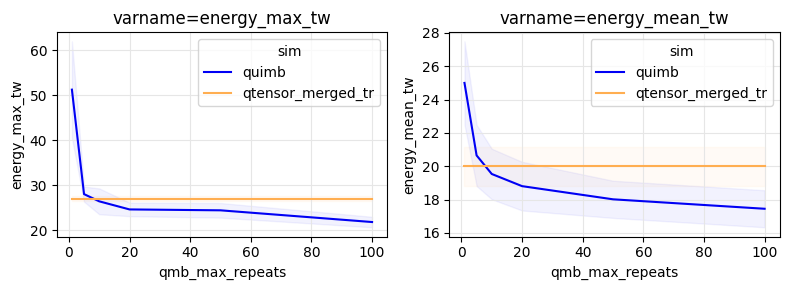

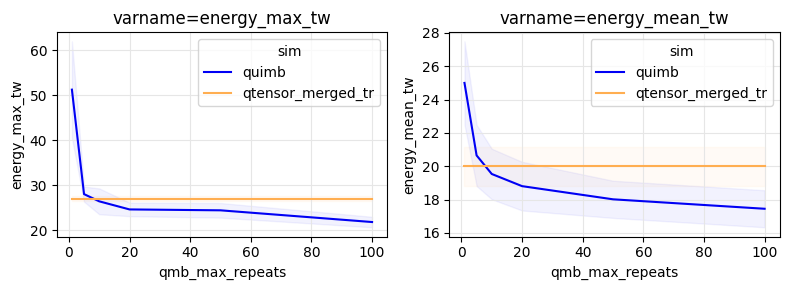

In [13]:
ex.plot_variables(('energy_max_tw', 'energy_mean_tw')
                  , distribution_var='seed'
                  , sim=['quimb', 'qtensor_merged_tr']
                  , qmb_max_repeats=[1, 5, 10, 20, 50, 100]
                  , qaoa_preset=['p4_n40']
                  , seed=range(5)
                 )

### Verify merged indices

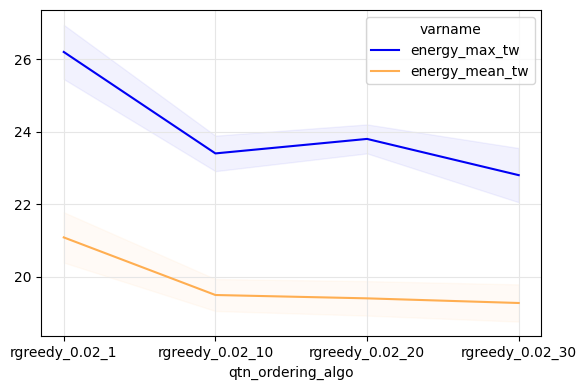

In [32]:
fig = ex.plot_variables(('energy_max_tw', 'energy_mean_tw')
                  , distribution_var='seed'
                  , sim=['qtensor_merged_tr']
                  , qtn_ordering_algo=[f'rgreedy_0.02_{x}' for x in[1, 10, 20, 30]]
                  , qaoa_preset=['p4_n26']
                  , seed=range(5)
                 )


[5434584, 18806924, 103796398, 4603502, 44269702, 37189824, 11038134, 34359440, 141667280, 46153694, 154136134, 30262446, 105126576, 274776574, 65550746, 7573074, 7495480, 198093056, 90468410, 248256408, 115556104, 26032304, 158750912, 167067204, 467265926, 729578238, 1321461566, 804974536, 1249017634, 9523976242, 1254059102, 188943060, 992784446, 159141776, 680344944, 471697134, 138317930, 126880474, 359132706]



[12639222, 6844990, 6075054, 24090052, 3888098, 1889986, 635928, 1045170, 5903342, 910438, 2576398, 2633894, 1386718, 1443450, 2475392, 43849466, 1970170, 1998502, 9808160, 10237486, 1071610, 3054542, 2242198, 6153858, 2660630, 23883834, 3241986, 7074586, 7791244, 17411616, 2174910, 2895208, 27098126, 1572962, 4443890, 1699220, 70746566, 6257394, 39008420]



[304433418, 676773470, 964659266, 174215494, 157711696, 375635446, 254592534, 516514620, 369933450, 730438838, 392529942, 256700822, 188092582, 209230368, 927633240, 784316848, 6889345396, 350995234, 316118418, 978340346, 501012302, 458678582, 1131849760, 818372790, 653957350, 5550497334, 9585154250, 6556702032, 171859424, 154507890, 4415406206, 148561444, 5516866, 14482098, 515546330, 165400354, 293289884, 13812980, 2413849698]



[65721464, 292316572, 12855458, 7805462, 257222642, 574222742, 867837582, 504009702, 435184422, 672017730, 199409232, 266335176, 703799262, 107287168, 767440080, 2299021570, 1720602132, 559409664, 285214920, 7813616, 81351604, 36348002, 2937926, 3260430, 47987342, 136109464, 1037565058, 8207868726, 183930782, 726174938, 3006639876, 76892624, 622911664, 619071016, 2865712, 78460206, 4493282890, 580982036, 142482382]



[4977232, 9532218, 70821654, 7947444, 66284340, 27600230, 16484704, 69314438, 96370390, 50848522, 136197230, 44636168, 149641178, 607849242, 72182940, 6410042, 4665078, 193163438, 131759728, 92298352, 62041720, 17830590, 113696624, 225294412, 170650670, 1657606284, 930486514, 830007946, 563341722, 13161497540, 599831830, 182449120, 1698734768, 159236638, 1740397302, 305330262, 101346658, 53122234, 1268835440]



[6486770, 8504950, 4574014, 30939770, 5590362, 1150530, 1457326, 1101782, 5351086, 884562, 1536022, 3328958, 1590768, 2765074, 3690286, 32228308, 2685546, 2691858, 8713946, 7404230, 1511634, 3713486, 1721254, 8560014, 3003154, 21470142, 2524638, 4734862, 12861186, 22526098, 1793476, 1873846, 19819354, 1118096, 3347390, 1407358, 41273026, 4802848, 77531392]



[218028112, 675923648, 1039191468, 358638670, 146413120, 257193030, 259167872, 904429462, 358130850, 693147768, 170618180, 291913950, 198309346, 157518446, 547133310, 473375342, 4124445030, 478840032, 670669328, 645002726, 3409836170, 173391846, 645161902, 864232526, 364730474, 1819324812, 12395392736, 14605867740, 45258718, 316308016, 4897733816, 98606694, 6483134, 35708274, 1039941942, 53150788, 193193566, 20652368, 5770418698]



[43414284, 141749018, 18191630, 12714778, 244516552, 742388022, 152655750, 334613860, 371214456, 310230624, 334392386, 238740320, 1372961466, 154421072, 484226034, 5324172126, 1591690078, 174109534, 273263566, 24448430, 51549954, 38158822, 4672648, 2768126, 96998994, 94501912, 1031600162, 4964017746, 212255090, 339430638, 2704958136, 68560646, 440648336, 639401880, 1622400, 40599990, 2444199560, 913444224, 303427138]



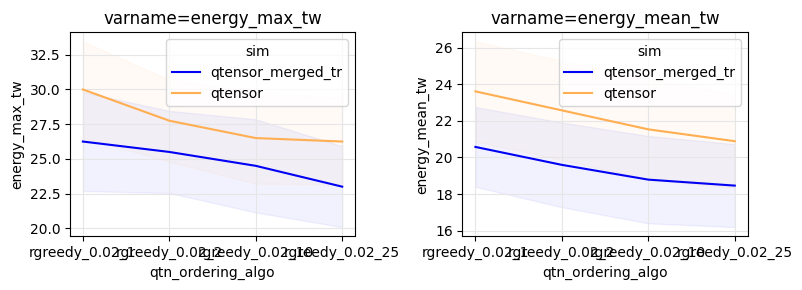

In [57]:
fig = ex.plot_variables(('energy_max_tw', 'energy_mean_tw')
                  , distribution_var='seed'
                  , sim=['qtensor_merged_tr', 'qtensor']
                  , qtn_ordering_algo=[f'rgreedy_0.02_{x}' for x in[1, 2, 10, 25]]
                  , qaoa_preset=['p4_n26']
                  , seed=range(25, 29)
                 )

In [44]:
ex.parallel = None

## Debugging of quimb

In [ ]:
xar_tr.sel(sim='quimb_Dsimp', N=18, p=3)

In [ ]:
@ex.provider
def energy_tws_max(energy_tws):
    return max(energy_tws)

In [ ]:
fig = ex.plot_variables2d(('energy_tws_max'),
                    sim=['quimb_Dsimp'],
                    N=[20, 24, 28],
                    p=[3],
                    qmb_max_repeats=[10],
                    n_processes=[1]
                   )

In [ ]:
fig = ex.plot_variables2d(('energy_tws_max'),
                    sim=['quimb'],
                    N=[20, 24, 28],
                    p=[3],
                    qmb_max_repeats=[10],
                    n_processes=[1]
                   )

In [ ]:
_time = ex.get_variable('energy_time', sim='quimb', N=26, p=4, seed=10)
_mem = ex.get_variable('energy_memory', sim='quimb', N=26, p=4, seed=10)
_time, _mem

In [ ]:
import autoray

In [ ]:
circ = quimb.tensor.circ_qaoa(terms, p, [0.1]*p, [0.2]*p)
def get_lightcone_circ(circ, G, where):
    rho = circ.get_rdm_lightcone_simplified(where, 'ADCRS', 1e-12)
    k_inds = tuple(circ.ket_site_ind(i) for i in where)
    b_inds = tuple(circ.bra_site_ind(i) for i in where)
    G_data = autoray.reshape(G, (2,)*2*len(where))
    output_inds = ()
    TG = quimb.tensor.Tensor(data=G_data, inds=output_inds + b_inds + k_inds)
    rho_G = rho | TG
    return rho_G
    

In [ ]:
rho = get_lightcone_circ(circ, ZZ, list(G.edges)[ix])
rho

In [ ]:
opt = cotengra.HyperOptimizer(max_repeats=10)
info_ns_tr = rho.contract(output_inds=(), get='path-info', optimize=info_ns.path)
np.log2(float(info_ns_tr.largest_intermediate))

Simplify with TG

In [ ]:
rho.full_simplify_(seq='D', atol=1e-12, output_inds=())

In [ ]:
info = rho.contract(output_inds=(), get='path-info', optimize=_inf[ix].path)
np.log2(float(info.largest_intermediate))

In [ ]:
def tn2eq(tn):
    i_ix = tuple(t.inds for t in tn)
    total_ix = tuple(quimb.utils.concat(i_ix))
    all_ix = tuple(quimb.utils.oset(total_ix))
    o_ix = tuple(quimb.tensor.tensor_core._gen_output_inds(total_ix))
    eq = quimb.tensor.tensor_core._inds_to_eq(all_ix, i_ix, o_ix)
    return eq

In [ ]:
qtensor.tests.qaoa_quimb.simulate_one(graph(26), p=4, max_repeats=10)

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_tws', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
), 
            distribution_var='seed',
           )

## Plot comparisons


In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
)
                     distr_
                    )
for ax in fig.axes[:]:
    ax.set_yscale('log')

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})

def pl(x, y, **kwargs):
    try:
        z = [max(i) if i else None for i in y]
        plt.plot(x, z, **kwargs)
    except Exception:
        z = None
    
fig = ex.plot_xarray( xar_tr.sel(
    varname=['energy_tws']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=4
)
    , plot_func=pl
)



In [ ]:
xar_tr = xar.transpose('varname', 'p', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_time']#, 'energy_memory']
    #, p=4
))

for ax in fig.axes:
    ax.set_yscale('log')

In [ ]:
    #export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]


    [ax.autoscale() for ax in axes]
    [ax.set_ylabel('Time, sec') for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]
    fig.suptitle('Time for single energy query on a single Skylake node', fontfamily='serif', style='italic')
    fig.set_size_inches(10.5, 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


In [ ]:
plot_xar_data(xar)

In [ ]:
def plot_xar_data_simple(xar_orig):
    xar = xar_orig.sel(p=3)
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log' )
        plt.xticks([10, 20, 50, 100, 200, 500])
    fig = ex.plot_xarray(xar, plot_func=custom_plot)
    from matplotlib.ticker import FormatStrFormatter

    fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%.i'))
    fig.gca().yaxis.set_major_formatter(FormatStrFormatter('%.i'))


    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)


    fig.gca().set_ylabel('Time, sec')
    fig.gca().set_xlabel('Number of qubits')
    fig.suptitle('Time for a quantum circuit simulation', fontfamily='serif', style='italic')
    plt.legend(['Our simulator', 'Caltech simulator', 'IBM simulator'])
    fig.set_size_inches(5., 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [ ]:
plot_xar_data_simple(xar)
plt.savefig('../../../data/figures/speed_comparison_simple_p3.png')
plt.savefig('../../../data/figures/speed_comparison_simple_p3.pdf')

## CLI

In [ ]:
#export
from qtensor_specs import cli, click

In [ ]:
#export
@cli.command()
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def time_comparison_xarray(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [ ]:
#export
import logging
ql = logging.getLogger('qiskit')
ql.setLevel(logging.ERROR)

In [ ]:
Ns = [10, 14]
ps = [2, 3]
xar = gen_time_data(Ns, ps)

In [ ]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()